# Movies

## Introduction
Over the past decade, information has grown at an exponential rate. With so much data now available, in-depth analysis can be performed on an increasingly wide variety of business-cases as well as incorporate an expanding number of key metrics. These data points can range from quantitative measures, such as revenues and budgets, to categorical classifications, such as genres and languages. The advantages offered by this information has allowed advanced predictive models to become commonplace. For instance, major companies in the movie industry have been gathering and applying movie information to implement performance forecasting systems and surprisingly effective recommendation engines for several years now. 

The purpose of this project is to personally experiment with some publicly available movie data to see what insights I might be able to gain.

In addition to exploratory analysis, this project briefly touches on revenue forecasting with machine learning to get a glimpse at the significance of each metric's relationship to revenue.

## Data Requirements
This project utilizes 5 data sources as follows:

1. TMDB Movies.csv
    * budget: The budget for the production of the movie  
    * genres: The genres of the movie
    * id: Movie ID number
    * keywords: Main descriptors of the movie
    * original_language: Original language of the movie
    * overview: Summary of movie
    * popularity: Popularity metric of TMDB users
    * production_companies: Production companies involved in the movie
    * production_countries: Countries that the movie was produced in
    * release_date: Date of movie's premiere
    * revenue: Revenues generated worldwide
    * runtime: Length of movie in minutes
    * spoken_languages: Available languages
    * title: Title of movie
    * vote_average: Average vote value of TMDB users
    * vote_count: Number of votes by TMDB users  


2. TMDB Credits.csv  
    * movie_id: Movie ID, corresponding to 'id' from TMDB Movies
    * title: Movie title
    * cast: Nested JSON of the movie's actors
    * crew: Nested JSON of the movie's crew (incl. Director)
  
  
3. OMDB API  
    * Title: Movie Title
    * Rated: Parental Guidance rating
    * Awards: Nested JSON of the movie's acclamations (incl. Oscars, Golden Globe, etc.)
    * Ratings: Nested JSON of the movies critic ratings (incl. Rotten Tomatoes and IMDB)
    * Metascore: Metascore rating
    * imdbRating: IMDB rating
    * imdbID: IMDB movie ID
  
  
4. MovieLens Metadata.csv
    * imdb_id: IMDB movie ID
    * belongs_to_collection: Nested JSON of the movie's franchise (if any)
  
  
5. US Consumer Price Index information provided by the U.S. Department of Labor Bureau of Labor Statistic
    * CPI by month for the years 1913-2019
  
  
## Methodology
The TMDB dataset acted as the primary dataframe with the other data sets serving as auxiliary information. 

OMDB data was gathered using the "OMDB with Caching" program that I designed, which directly accesses the OMDB API to retrieve additional movie ratings info. 
MovieLens data was extracted from an excel file available on Kaggle to gain movie franchise info.  
Movie information from both OMDB and MovieLens were appended to the TMDB movie list based on the imdb_ID.

Consumer price index data was collected using using the "CPI Scraper" program that I designed, which utilizes BeautifulSoup to extract the CPI data table from the webpag
and applied to each movie based on its year of release in order to account for inflation.

Data cleansing included filling in or dropping missing information as well as extracting relevant details from nested JSON objects.
Data tables were then restructured to facilitate visualizations and engineering the revenue forecaster.

Comprehensive visualizations and analysis were conducted in a Tableau workbook.

Revenue Forecasting was implemented using a Random Forest Regressor model.

## Discussion
From my exploratory analysis, I found that June has consistently been the month with highest total revenues for the past 3+ decades. This is almost definitely due to the timing of Summer Vacation for schools, during which time kids and their families have much more time to visit theaters. And indeed, the most popular genres during the Summer include Family and Animation. It is probable that target release dates are set with these months in mind.

Considering movies from a higher level, the highest performing movies (revenue-wise) tend to belong to popular franchises; the most profitable genre, on average, is Action; and PG-13 rated movies have the highest average revenues, most likely since they appeal to the largest audience. 

Surprisingly, there is no strong relationship between a movie's revenue and the movie critic ratings, awards, or nominations it received.

Currently, Paramount Pictures has produced films with the largest budgets in total, but Marvel Studios has produced the most profitable on average.

Steven Spielberg is the director with the greatest revenue in total and whose films have won the most awards.

The actor that has been in the highest performing movies in total is Robert Downey Jr., mostly as Iron Man. 
Johnny Depp is a close second, with a significantly more diverse career, but far fewer roles in blockbusters.

In forecasting a movie's revenues, the most important features to consider are its budget, number of user ratings on TMDB, and its popularity. Other features were not particularly helpful in determining revenues.

## Potential Enhancements
I'd like to expand my analysis to include investigation of movie overviews, plots, and keywords.

In addition, various other algorithms may prove to be more effective for forecasting movie revenues and would definitely be worth exploring. 

Furthermore, with this cleansed dataframe, I am also interested in taking this application in a completely different direction: recommender systems. More specifically, a content-based filtering recommendation engine could be effectively engineered as a continuation of this program with the data tables that I've constructed in this program. Furthermore, I would also like to find a dataset that details user accounts and their respective ratings of the movies I have gathered here to create a collaborative-based filtering recommender based on user profiles.

---
---

In [313]:
import datetime as datetime

import pandas as pd
import numpy as np

import json
import requests
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Load TMDB Dataset

In [314]:
'''
Read in datatables from csv files
'''
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

In [315]:
print("{} movies with {} features".format(movies.shape[0], movies.shape[1]))
movies.head(3)

4803 movies with 20 features


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [316]:
print("{} movie credits with {} features.".format(credits.shape[0],credits.shape[1]))
credits.head(3)

4803 movie credits with 4 features.


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


### Preliminary Cleansing

In [317]:
'''
Convert to datetime
Breakout month and year
'''
movies['release_date'] = pd.to_datetime(movies['release_date'])

movies['release_month'] = movies['release_date'].apply(lambda x: x.month)
movies['release_year'] = movies['release_date'].apply(lambda x: x.year)

In [318]:
'''
Convert json columns from string to json lists
'''
movies_json_cols = ['genres','keywords','production_companies','production_countries','spoken_languages']
for col in movies_json_cols:
    movies[col] = movies[col].apply(json.loads)
    
credits_json_cols = ['cast','crew']
for col in credits_json_cols:
    credits[col] = credits[col].apply(json.loads)

In [319]:
'''
Function to extract relevant values of specified keys from json columns

Inputs: DataFrame, list of columns to extract from, list of keys to extract from each column
Output: Modifies the provided DataFrame (adds new columns with extracted values)
'''
def json_to_list(df, col_list, key_list):
    for col in col_list:
        for key in key_list:
            df[col+"_"+key] = df[col]
            for idx, row in df.iterrows():
                lst = []
                for item in df[col][idx]:
                    lst.append(item[key])
                df.at[idx,col+"_"+key] = lst
    return None

In [320]:
json_to_list(movies, movies_json_cols, ['name'])
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,release_month,release_year,genres_name,keywords_name,production_companies_name,production_countries_name,spoken_languages_name
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,Avatar,7.2,11800,12.0,2009.0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]"
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,Pirates of the Caribbean: At World's End,6.9,4500,5.0,2007.0,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English]
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,Spectre,6.3,4466,10.0,2015.0,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]"


In [321]:
json_to_list(credits, ['cast'], ['name', 'gender'])
json_to_list(credits, ['crew'], ['name', 'job'])
credits.head(3)

,movie_id,title,cast,crew,cast_name,cast_gender,crew_name,crew_job
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...","[Sam Worthington, Zoe Saldana, Sigourney Weave...","[2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Editor, Production Design, Sound Designer, Su..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...","[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Director of Photography, Director, Producer, ..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...","[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, ...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Original Music Composer, Director, Set Decora..."


In [322]:
'''
Extract the first Director from the crew (used to help investigate whether movie titles were correctly matched to OMDB database info)
'''
for i,r in credits.iterrows():
    if 'Director' in r['crew_job']:
        idx = r['crew_job'].index('Director')
        credits.loc[i,'director'] = r['crew_name'][idx]
credits.head(3)

,movie_id,title,cast,crew,cast_name,cast_gender,crew_name,crew_job,director
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...","[Sam Worthington, Zoe Saldana, Sigourney Weave...","[2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Editor, Production Design, Sound Designer, Su...",James Cameron
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...","[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Director of Photography, Director, Producer, ...",Gore Verbinski
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...","[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, ...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Original Music Composer, Director, Set Decora...",Sam Mendes


In [323]:
'''
Join movies to their corresponding credits
'''
movies_credits = pd.merge(movies, credits, left_on='id', right_on='movie_id', how='outer')
print(movies_credits.shape)

(4803, 36)


---
Number of rows did not increase, which indicates a successful 1:1 join between movies and credits with no unmatched items

---

In [324]:
'''
Drop unneeded fields
'''
cols_drop = ['original_title','status','tagline','homepage','id','title_y'] + movies_json_cols + credits_json_cols

movies_credits.drop(cols_drop, axis=1, inplace=True)
movies_credits.rename(columns={'title_x': 'title'}, inplace=True)

print(movies_credits.shape)
movies_credits.head(3)

(4803, 23)


,budget,original_language,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,keywords_name,production_companies_name,production_countries_name,spoken_languages_name,movie_id,cast_name,cast_gender,crew_name,crew_job,director
0,237000000,en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Avatar,7.2,11800,...,"[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]",19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Editor, Production Design, Sound Designer, Su...",James Cameron
1,300000000,en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,...,"[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English],285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Director of Photography, Director, Producer, ...",Gore Verbinski
2,245000000,en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,Spectre,6.3,4466,...,"[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]",206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, ...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Original Music Composer, Director, Set Decora...",Sam Mendes


## Additional Data Integration

### OMDB

In [325]:
'''
Read in movie details retrieved from OMDB Database
'''
omdb = pd.read_csv('omdb.csv')
omdb.columns

Index(['TMDB Title', 'Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre',
       'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards',
       'Poster', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID',
       'Type', 'DVD', 'BoxOffice', 'Production', 'Website', 'Response',
       'Error', 'totalSeasons'],
      dtype='object')

In [326]:
'''
Drop unneeded/duplicate fields
'''
unneeded_cols = ['Year','Runtime','Language','Type','Poster','DVD','Website','Error','totalSeasons']
omdb.drop(unneeded_cols, axis=1, inplace=True)

In [327]:
'''
Extract Rotten Tomatoes rating
'''
# replace single quotes with double quotes for json.loads
omdb['Ratings'] = omdb['Ratings'].str.replace("\'", "\"")

for i,r in omdb.iterrows():
    # some Ratings are empty
    try:
        r['Ratings'] = json.loads(r['Ratings'])
    except:
        continue
    
    # collect sources and scores     
    sources = []
    values = []
    for item in r['Ratings']:
        sources.append(item['Source'])
        values.append(item['Value'])
        
    # pinpoint Rotten Tomatoes    
    if 'Rotten Tomatoes' in sources:
        omdb.loc[i, 'Rotten Tomatoes'] = values[sources.index('Rotten Tomatoes')]
        # Convert to number
        omdb.loc[i, 'Rotten Tomatoes'] = pd.to_numeric(omdb.loc[i, 'Rotten Tomatoes'].replace("%",""))

In [328]:
'''
Convert Released date to datetime
'''
omdb['Released'] = pd.to_datetime(omdb['Released'])

In [329]:
'''
Convert BoxOffice to numeric
'''
omdb['BoxOffice'] = pd.to_numeric(omdb['BoxOffice'].str.replace('[$,]','', regex=True))
omdb.rename(columns={'BoxOffice':'Domestic Revenue'}, inplace=True)

In [330]:
'''
Breakout awards
'''
omdb['Oscar Awards'] = omdb['Awards'].str.extract(r'Won (\d*) Oscar')
omdb['Oscar Nominations'] = omdb['Awards'].str.extract(r'Nominated for (\d*) Oscar')

omdb['BAFTA Film Awards'] = omdb['Awards'].str.extract(r'Won (\d*) BAFTA Film')
omdb['BAFTA Film Nominations'] = omdb['Awards'].str.extract(r'Nominated for (\d*) BAFTA Film')

omdb['Golden Globe Awards'] = omdb['Awards'].str.extract(r'Won (\d*) Golden Globe')
omdb['Golden Globe Nominations'] = omdb['Awards'].str.extract(r'Nominated for (\d*) Golden Globe')

omdb['Other Awards'] = omdb['Awards'].str.extract(r'(\d*) win')
omdb['Other Nominations'] = omdb['Awards'].str.extract(r'(\d*) nomination')

# Fill NaN with zeroes
omdb[['Awards','Oscar Awards', 'Oscar Nominations','BAFTA Film Awards','BAFTA Film Nominations','Golden Globe Awards',
                    'Golden Globe Nominations','Other Awards','Other Nominations']] = \
omdb[['Awards','Oscar Awards', 'Oscar Nominations','BAFTA Film Awards','BAFTA Film Nominations','Golden Globe Awards',
                    'Golden Globe Nominations','Other Awards','Other Nominations']].fillna(0)

# cast to int
omdb[['Oscar Awards', 'Oscar Nominations','BAFTA Film Awards','BAFTA Film Nominations','Golden Globe Awards',
                    'Golden Globe Nominations','Other Awards','Other Nominations']].astype('int32', inplace=True)

omdb.head(3)

,TMDB Title,Title,Rated,Released,Genre,Director,Writer,Actors,Plot,Country,...,Response,Rotten Tomatoes,Oscar Awards,Oscar Nominations,BAFTA Film Awards,BAFTA Film Nominations,Golden Globe Awards,Golden Globe Nominations,Other Awards,Other Nominations
0,102 Dalmatians,102 Dalmatians,G,2000-11-22,"Adventure, Comedy, Family",Kevin Lima,"Dodie Smith (novel), Kristen Buckley (story), ...","Glenn Close, Gérard Depardieu, Ioan Gruffudd, ...",Cruella DeVil gets out of prison and goes afte...,"USA, UK",...,True,31,0,1,0,0,0,0,1,6
1,13 Hours: The Secret Soldiers of Benghazi,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,0,0,0,0,0,0,0,0
2,2 Fast 2 Furious,2 Fast 2 Furious,PG-13,2003-06-06,"Action, Crime, Thriller",John Singleton,"Gary Scott Thompson (characters), Michael Bran...","Paul Walker, Tyrese Gibson, Eva Mendes, Cole H...",Former cop Brian O'Conner is called upon to bu...,"USA, Germany",...,True,36,0,0,0,0,0,0,4,13


In [331]:
'''
Join OMDB details with primary dataframe
'''
movies_credits_omdb = pd.merge(movies_credits, omdb, left_on='title', right_on='TMDB Title', how='outer')

print(movies_credits_omdb.columns)
print(movies_credits_omdb.shape)

Index(['budget', 'original_language', 'overview', 'popularity', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count',
       'release_month', 'release_year', 'genres_name', 'keywords_name',
       'production_companies_name', 'production_countries_name',
       'spoken_languages_name', 'movie_id', 'cast_name', 'cast_gender',
       'crew_name', 'crew_job', 'director', 'TMDB Title', 'Title', 'Rated',
       'Released', 'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Country',
       'Awards', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID',
       'Domestic Revenue', 'Production', 'Response', 'Rotten Tomatoes',
       'Oscar Awards', 'Oscar Nominations', 'BAFTA Film Awards',
       'BAFTA Film Nominations', 'Golden Globe Awards',
       'Golden Globe Nominations', 'Other Awards', 'Other Nominations'],
      dtype='object')
(4803, 51)


---
Since the OMDB API searches by movie title and returns the best match, the OMDB API may return incorrect information for certain movies
that have very similar titles to each other (e.g. matching sequels to prequels)

As such, I extracted potential problem instances and analyzed the differences in excel 

---

In [332]:
'''
Extract potential mismatches 
'''
# Calculate difference in release dates (in days)
movies_credits_omdb['release_date_diff'] = abs((movies_credits_omdb['release_date'] - movies_credits_omdb['Released']).dt.days)

# Look at items that have differing movie titles (after stripping punctuation and white space) and 
# have a difference in release date of over 100 days
check = movies_credits_omdb[(movies_credits_omdb['Title'].notnull()) & 
                            (movies_credits_omdb['Title'].str.replace('[^\w]','').str.upper() != 
                             movies_credits_omdb['TMDB Title'].str.replace('[^\w]','').str.upper())]

# Output to excel
check.to_csv('check.csv')

---
In investigating the movie titles that differed significantly, I found that several titles were, actually, correctly matched; one title was simply the abridged version of the other. In these cases, I noticed that most of these instances had a difference in release date of under 85 days.

As such, I chose to filter out movies that had significantly differing titles *and* had significantly different recorded release dates. Though this over-prunes 3 records, I believe this to be the most cost-effective method.

---

In [333]:
'''
Scrub the incorrect OMDB data.
Remove unneeded/duplicate OMDB fields.
'''

omdb_columns = ['TMDB Title', 'Title', 'Rated', 'Released', 'Genre', 'Director',
               'Writer', 'Actors', 'Plot', 'Country', 'Awards', 'Ratings', 'Metascore',
               'imdbRating', 'imdbVotes', 'Domestic Revenue', 'Production',
               'Rotten Tomatoes', 'Oscar Awards', 'Oscar Nominations',
               'BAFTA Film Awards', 'BAFTA Film Nominations', 'Golden Globe Awards',
               'Golden Globe Nominations', 'Other Awards', 'Other Nominations', 'Response']

movies_credits_omdb.loc[(movies_credits_omdb['Title'].isnull()) | 
                                  
                        ((movies_credits_omdb['Title'].str.replace('[^\w]','').str.upper() != 
                         movies_credits_omdb['TMDB Title'].str.replace('[^\w]','').str.upper()) &

                        (movies_credits_omdb['release_date_diff'] > 85)), omdb_columns] = np.nan

unneeded_cols = ['TMDB Title', 'Title','Writer','Actors','Production','Released','release_date_diff',
                'Ratings','imdbVotes','Genre','Country']

movies_credits_omdb.drop(unneeded_cols, axis=1, inplace=True)

In [334]:
movies_credits_omdb.columns

Index(['budget', 'original_language', 'overview', 'popularity', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count',
       'release_month', 'release_year', 'genres_name', 'keywords_name',
       'production_companies_name', 'production_countries_name',
       'spoken_languages_name', 'movie_id', 'cast_name', 'cast_gender',
       'crew_name', 'crew_job', 'director', 'Rated', 'Director', 'Plot',
       'Awards', 'Metascore', 'imdbRating', 'imdbID', 'Domestic Revenue',
       'Response', 'Rotten Tomatoes', 'Oscar Awards', 'Oscar Nominations',
       'BAFTA Film Awards', 'BAFTA Film Nominations', 'Golden Globe Awards',
       'Golden Globe Nominations', 'Other Awards', 'Other Nominations'],
      dtype='object')

### MovieLens Dataset (Franchise info)

In [335]:
'''
Load data from csv
'''
meta = pd.read_csv('movies_metadata.csv')
meta = meta[['belongs_to_collection', 'imdb_id', 'title']]

/home/jupyterlab/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [336]:
'''
Extract franchise names
'''
franchises = meta[['belongs_to_collection','imdb_id']][meta['belongs_to_collection'].notnull()]
franchises['Franchise'] = franchises['belongs_to_collection'].apply(ast.literal_eval) \
                                                                .apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)

In [337]:
'''
Join franchise info back to full dataframe
'''
movies_credits_omdb_franch = pd.merge(left=movies_credits_omdb, right=franchises[['Franchise','imdb_id']],
                                      left_on='imdbID', right_on='imdb_id', how='left')

In [338]:
'''
Drop unneeded fields
'''
unneeded_cols = ['imdbID','imdb_id']
movies_credits_omdb_franch.drop(columns=unneeded_cols, inplace=True)

### Consumer Price Index Data  
In order to account for inflation over the years, I will be incorporating US Consumer Price Index information provided by the U.S. Department of Labor Bureau of Labor Statistic.

In [339]:
'''
Load CPI data from csv, which was created with the 'CPI Scraper' notebook (see github repository)
'''
cpi_df = pd.read_csv('cpi_df.csv')
cpi_df.head(5)

,Year,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0
1,1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1
2,1915,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3
3,1916,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6
4,1917,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7


In [340]:
# drop incomplete 2019 data
cpi_df.drop(cpi_df.index[cpi_df['Year'] == 2019], axis=0, inplace=True)

In [341]:
# convert month names to int
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 'July': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
cpi_df.rename(columns=month_dict, inplace=True)
cpi_df.head(3)

,Year,1,2,3,4,5,6,7,8,9,10,11,12
0,1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0
1,1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1
2,1915,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3


In [342]:
# stack data
cpi_df = pd.melt(cpi_df,id_vars='Year',value_vars=range(1,13))

# cast value as float
cpi_df['value'].astype('float64')

cpi_df.head(10)

,Year,variable,value
0,1913,1,9.8
1,1914,1,10
2,1915,1,10.1
3,1916,1,10.4
4,1917,1,11.7
5,1918,1,14
6,1919,1,16.5
7,1920,1,19.3
8,1921,1,19
9,1922,1,16.9


In [343]:
# rename columns
cpi_df.rename(columns={'variable': 'Month','value': 'CPI'}, inplace=True)
cpi_df.head(3)

,Year,Month,CPI
0,1913,1,9.8
1,1914,1,10
2,1915,1,10.1


In [344]:
'''
Join with full dataframe
'''
movies_credits_omdb_franch_cpi = pd.merge(left=movies_credits_omdb_franch, right=cpi_df,
                                      left_on=['release_year','release_month'], right_on=['Year','Month'], how='left')
movies_credits_omdb_franch_cpi[['release_date','Year','Month','CPI']].head(10)

,release_date,Year,Month,CPI
0,2009-12-10,2009.0,12,215.949
1,2007-05-19,2007.0,5,207.9
2,2015-10-26,2015.0,10,237.838
3,2012-07-16,2012.0,7,229.104
4,2012-03-07,2012.0,3,229.392
5,2007-05-01,2007.0,5,207.9
6,2010-11-24,2010.0,11,218.803
7,2015-04-22,2015.0,4,236.599
8,2009-07-07,2009.0,7,215.351
9,2016-03-23,2016.0,3,238.132


In [345]:
# drop unneeded columns
movies_credits_omdb_franch_cpi.drop(['Year','Month'], axis=1, inplace=True)
movies_credits_omdb_franch_cpi.columns

Index(['budget', 'original_language', 'overview', 'popularity', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count',
       'release_month', 'release_year', 'genres_name', 'keywords_name',
       'production_companies_name', 'production_countries_name',
       'spoken_languages_name', 'movie_id', 'cast_name', 'cast_gender',
       'crew_name', 'crew_job', 'director', 'Rated', 'Director', 'Plot',
       'Awards', 'Metascore', 'imdbRating', 'Domestic Revenue', 'Response',
       'Rotten Tomatoes', 'Oscar Awards', 'Oscar Nominations',
       'BAFTA Film Awards', 'BAFTA Film Nominations', 'Golden Globe Awards',
       'Golden Globe Nominations', 'Other Awards', 'Other Nominations',
       'Franchise', 'CPI'],
      dtype='object')

In [346]:
with pd.option_context('display.max_columns', None):
    display(movies_credits_omdb_franch_cpi.head(3))

,budget,original_language,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,release_month,release_year,genres_name,keywords_name,production_companies_name,production_countries_name,spoken_languages_name,movie_id,cast_name,cast_gender,crew_name,crew_job,director,Rated,Director,Plot,Awards,Metascore,imdbRating,Domestic Revenue,Response,Rotten Tomatoes,Oscar Awards,Oscar Nominations,BAFTA Film Awards,BAFTA Film Nominations,Golden Globe Awards,Golden Globe Nominations,Other Awards,Other Nominations,Franchise,CPI
0,237000000,en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Avatar,7.2,11800,12,2009.0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]",19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Editor, Production Design, Sound Designer, Su...",James Cameron,PG-13,James Cameron,A paraplegic marine dispatched to the moon Pan...,Won 3 Oscars. Another 85 wins & 128 nominations.,83.0,7.8,749700000.0,1.0,82,3,0,0,0,0,0,85,128,Avatar Collection,215.949
1,300000000,en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,5,2007.0,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English],285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Director of Photography, Director, Producer, ...",Gore Verbinski,PG-13,Gore Verbinski,"Captain Barbossa, Will Turner and Elizabeth Sw...",Nominated for 2 Oscars. Another 20 wins & 44 n...,50.0,7.1,309404152.0,1.0,44,0,2,0,0,0,0,20,44,Pirates of the Caribbean Collection,207.9
2,245000000,en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,Spectre,6.3,4466,10,2015.0,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]",206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, ...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Original Music Composer, Director, Set Decora...",Sam Mendes,PG-13,Sam Mendes,A cryptic message from 007's past sends him pi...,Won 1 Oscar. Another 7 wins & 32 nominations.,60.0,6.8,208777731.0,1.0,64,1,0,0,0,0,0,7,32,James Bond Collection,237.838


## Exploratory Analysis

### Missing Values Assessment

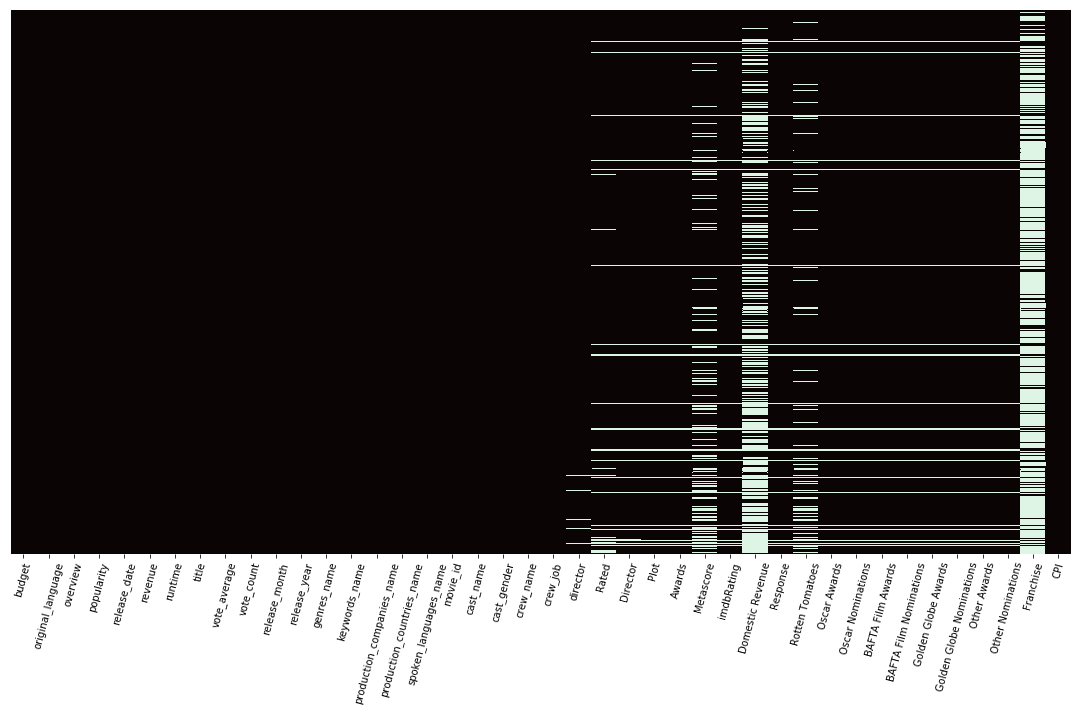

budget                          0
original_language               0
overview                        4
popularity                      0
release_date                    1
revenue                         0
runtime                         3
title                           0
vote_average                    0
vote_count                      0
release_month                   1
release_year                    1
genres_name                     0
keywords_name                   0
production_companies_name       0
production_countries_name       0
spoken_languages_name           0
movie_id                        0
cast_name                       0
cast_gender                     0
crew_name                       0
crew_job                        0
director                       32
Rated                         290
Director                      204
Plot                          198
Awards                        189
Metascore                     929
imdbRating                    196
Domestic Reven

In [347]:
'''
Visualize missing values
'''
fig, ax = plt.subplots(figsize=(19,10))         
sns.heatmap(movies_credits_omdb_franch_cpi.isnull(), cmap='mako', cbar=False, yticklabels=False, ax=ax)
plt.xticks(rotation=75)

plt.show()

print(movies_credits_omdb_franch_cpi.isna().sum())

---
The vast majority of the data provided by the TMDB file are complete. The handful of missing items could feasibly even be filled in manually. Intuitively, this seems like a poor practice, so I will instead simply be dropping the two instances.

However, many movies were not found in the OMDB API, which provided information relevant to ratings, awards, and the domestic revenue amount.
Considering how half the features of these movies are therefore missing and would need to be filled in with approximations, the reliability of these datapoints would be extraordinarily low. As such, these records will be dropped from the dataframe.

I will be assuming that missing ratings are Unrated movies.
I will be assuming that an empty Awards instance indicates zero awards and zero nominations.
Many franchises are also missing. This is largely due to the fact that most movies do not belong to a franchise.

For missing OMDB Directors, I will be filling in with what TMDB has recorded for Directors.
Ultimately, I plan to categorize directors as either "well-known" or "not well-known" and any remaining NaN directors will be labeled as "not well-known".

Since many ratings are missing for Metascore and Rotten Tomatoes, taking the average of all available scores may prove to be more robust for modeling.

Domestic Revenue may be approximated by taking into utilizing average domestic revenue: global revenue ratio per country. However, since so many data points are missing, it may make sense to drop this field if the ratios have high distributions per country.

---

In [348]:
'''
Drop NaN
'''
movies_credits_omdb_franch_cpi = movies_credits_omdb_franch_cpi[movies_credits_omdb_franch_cpi['Response'] == True]
movies_credits_omdb_franch_cpi.dropna(subset=['runtime', 'release_date'], inplace=True)

In [349]:
'''
Fill in for missing TMDB directors with OMDB Directors
Drop OMDB Directors
'''
movies_credits_omdb_franch_cpi['director'] = np.where(movies_credits_omdb_franch_cpi['director'].isna(), 
                                                      movies_credits_omdb_franch_cpi['Director'], 
                                                      movies_credits_omdb_franch_cpi['director'])

movies_credits_omdb_franch_cpi.drop(['Director'], axis=1, inplace=True)

In [350]:
'''
Fill in NaN overview, Plot, Franchise with empty string
Fill in NaN Rated with "Not Rated"
'''
with pd.option_context('mode.chained_assignment', None):
    movies_credits_omdb_franch_cpi['overview'][movies_credits_omdb_franch_cpi['overview'].isna()] = ''
    movies_credits_omdb_franch_cpi['Plot'][movies_credits_omdb_franch_cpi['Plot'].isna()] = ''
    movies_credits_omdb_franch_cpi['Franchise'][movies_credits_omdb_franch_cpi['Franchise'].isna()] = ''
    movies_credits_omdb_franch_cpi['Rated'][movies_credits_omdb_franch_cpi['Rated'].isna()] = 'Not Rated'

In [351]:
'''
Drop movies where imdbRating, Rotten Tomatoes, and Metascore are all missing
'''
movies_credits_omdb_franch_cpi.dropna(subset=['imdbRating','Rotten Tomatoes','Metascore'], how='all', inplace=True)

In [352]:
'''
When Rotten Tomatoes and Metascore are both missing, set to imdbRating
'''
with pd.option_context('mode.chained_assignment', None):
    movies_credits_omdb_franch_cpi['Rotten Tomatoes'][(movies_credits_omdb_franch_cpi['Rotten Tomatoes'].isna())
                                                        & (movies_credits_omdb_franch_cpi['Metascore'].isna())] = \
            movies_credits_omdb_franch_cpi['imdbRating'] * 10

    movies_credits_omdb_franch_cpi['Metascore'][(movies_credits_omdb_franch_cpi['Rotten Tomatoes'].isna())
                                                    & (movies_credits_omdb_franch_cpi['Metascore'].isna())] = \
        movies_credits_omdb_franch_cpi['imdbRating'] * 10

In [353]:
'''
Set the remaining missing scores to be the average of the two available scores
'''
with pd.option_context('mode.chained_assignment', None):
    movies_credits_omdb_franch_cpi['Rotten Tomatoes'][movies_credits_omdb_franch_cpi['Rotten Tomatoes'].isna()] = \
            ((movies_credits_omdb_franch_cpi['imdbRating'] * 10) + movies_credits_omdb_franch_cpi['Metascore']) / 2
    movies_credits_omdb_franch_cpi['Metascore'][movies_credits_omdb_franch_cpi['Metascore'].isna()] = \
            ((movies_credits_omdb_franch_cpi['imdbRating'] * 10) + movies_credits_omdb_franch_cpi['Rotten Tomatoes']) / 2

In [354]:
'''
Check NaN count
'''
print(movies_credits_omdb_franch_cpi.isna().sum())

budget                          0
original_language               0
overview                        0
popularity                      0
release_date                    0
revenue                         0
runtime                         0
title                           0
vote_average                    0
vote_count                      0
release_month                   0
release_year                    0
genres_name                     0
keywords_name                   0
production_companies_name       0
production_countries_name       0
spoken_languages_name           0
movie_id                        0
cast_name                       0
cast_gender                     0
crew_name                       0
crew_job                        0
director                        0
Rated                           0
Plot                            0
Awards                          0
Metascore                       0
imdbRating                      0
Domestic Revenue             2220
Response      

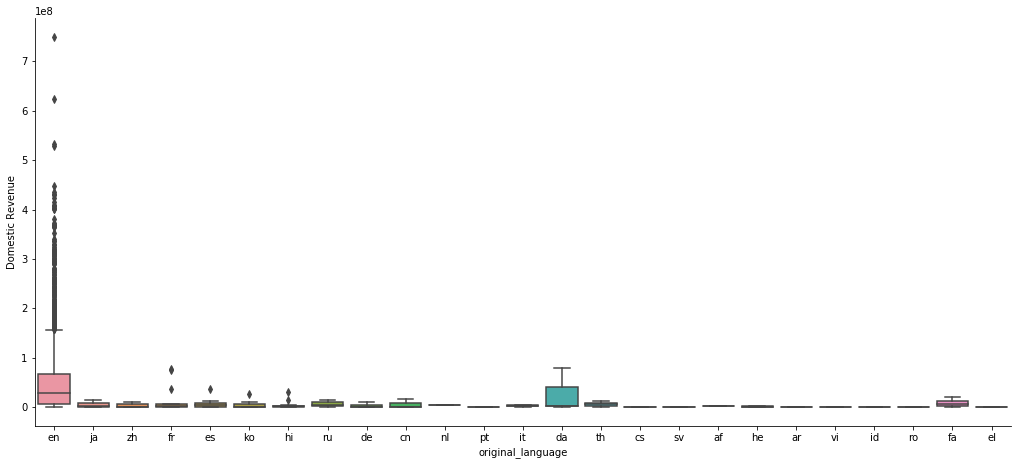

In [355]:
'''
Analyze Domestic Revenues
'''
domRev_df = movies_credits_omdb_franch_cpi[['original_language','Domestic Revenue']][movies_credits_omdb_franch_cpi['Domestic Revenue'].notna()]
domRev_df['Domestic Revenue'].astype('float64')

fig, ax = plt.subplots()
fig.set_size_inches(17.5,7.5)
sns.boxplot(data=domRev_df, x='original_language', y='Domestic Revenue', orient='v', ax=ax)    
sns.despine()

---
Distribution does not look promising so I am opting to drop Domestic Revenue from the dataset

---

In [356]:
movies_credits_omdb_franch_cpi.drop('Domestic Revenue', axis=1, inplace=True)

### Account for Inflation

In [357]:
'''
Adjust revenue, budget, and Domestic Revenue to present value: Jan 2019
'''
# calculate CPI multiplier
CPI_BASE = float(cpi_df.loc[(cpi_df['Year'] == 2018) & (cpi_df['Month'] == 12), 'CPI'].item())

movies_credits_omdb_franch_cpi['CPI Multiplier'] = movies_credits_omdb_franch_cpi['CPI'].astype('float64') / CPI_BASE

# apply CPI multiplier to  revenue, budget, and Domestic Revenue
movies_credits_omdb_franch_cpi['adj_revenue'] = movies_credits_omdb_franch_cpi['revenue'].astype('float64') * \
                                                movies_credits_omdb_franch_cpi['CPI Multiplier']
movies_credits_omdb_franch_cpi['adj_budget'] = movies_credits_omdb_franch_cpi['budget'].astype('float64') * \
                                                movies_credits_omdb_franch_cpi['CPI Multiplier']

with pd.option_context('display.max_columns', None):
    display(movies_credits_omdb_franch_cpi.head(3))

,budget,original_language,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,release_month,release_year,genres_name,keywords_name,production_companies_name,production_countries_name,spoken_languages_name,movie_id,cast_name,cast_gender,crew_name,crew_job,director,Rated,Plot,Awards,Metascore,imdbRating,Response,Rotten Tomatoes,Oscar Awards,Oscar Nominations,BAFTA Film Awards,BAFTA Film Nominations,Golden Globe Awards,Golden Globe Nominations,Other Awards,Other Nominations,Franchise,CPI,CPI Multiplier,adj_revenue,adj_budget
0,237000000,en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Avatar,7.2,11800,12,2009.0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]",19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Editor, Production Design, Sound Designer, Su...",James Cameron,PG-13,A paraplegic marine dispatched to the moon Pan...,Won 3 Oscars. Another 85 wins & 128 nominations.,83,7.8,1.0,82,3,0,0,0,0,0,85,128,Avatar Collection,215.949,0.859557,2.396414e+09,2.037149e+08
1,300000000,en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,5,2007.0,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English],285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Director of Photography, Director, Producer, ...",Gore Verbinski,PG-13,"Captain Barbossa, Will Turner and Elizabeth Sw...",Nominated for 2 Oscars. Another 20 wins & 44 n...,50,7.1,1.0,44,0,2,0,0,0,0,20,44,Pirates of the Caribbean Collection,207.9,0.827519,7.952454e+08,2.482556e+08
2,245000000,en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,Spectre,6.3,4466,10,2015.0,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]",206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, ...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Original Music Composer, Director, Set Decora...",Sam Mendes,PG-13,A cryptic message from 007's past sends him pi...,Won 1 Oscar. Another 7 wins & 32 nominations.,60,6.8,1.0,64,1,0,0,0,0,0,7,32,James Bond Collection,237.838,0.946683,8.337196e+08,2.319373e+08


---
The following section breaks out columns containing lists into numerous binary columns (one column per possible list item)
e.g. the genres_name column will be split out into the following columns: Action, Adventure, Fantasy, Science Fiction, etc.

This will allow for far easier filtering/selection of rows based on items in these lists

Columns to be broken out include genres_name, production_companies_name, production_countries_name, spoken_languages_name, and cast_name
(These columns will be broken out into separate dataframes to prevent the number of columns from becoming too many to manage)

---

In [358]:
def list_to_binary(col, lst):
    '''
    If the name of column is in the list, return 1; else return 0
    '''
    if col in lst:
        return 1
    return 0

#### Genres

In [359]:
'''
Convert genres to binary columns
'''
# create unique list of possible genres
all_genres = []
for i,r in movies_credits_omdb_franch_cpi.iterrows():
    genres = r["genres_name"]
    
    for g in genres:
        if g not in all_genres:
            all_genres.append(g)
print(all_genres)

['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign', 'TV Movie']


In [360]:
# create dataframe with top production companies as individual columns for each movie
genres_df = pd.concat([movies_credits_omdb_franch_cpi[['movie_id', 'title', 'genres_name']],pd.DataFrame(columns=all_genres)], sort=False)
print(genres_df.columns)

Index(['movie_id', 'title', 'genres_name', 'Action', 'Adventure', 'Fantasy',
       'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family',
       'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War',
       'Music', 'Documentary', 'Foreign', 'TV Movie'],
      dtype='object')


In [361]:
# apply binary conversion
for g in all_genres:
    genres_df[g] = movies_credits_omdb_franch_cpi['genres_name'].apply(lambda x: list_to_binary(g, x))
    
with pd.option_context('display.max_columns', None):
    display(genres_df.head(3))

,movie_id,title,genres_name,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
0,19995.0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,285.0,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,206647.0,Spectre,"[Action, Adventure, Crime]",1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [362]:
'''
Breakout all genres lists into rows for tableau
'''
genres_df_tableau = movies_credits_omdb_franch_cpi['genres_name'].apply(pd.Series) \
                                        .merge(movies_credits_omdb_franch_cpi[['movie_id','title','genres_name']], 
                                               left_index = True, right_index = True) \
                                        .melt(id_vars = ['title', 'movie_id', 'genres_name'], value_name = "genre") \
                                        .drop("variable", axis = 1) \
                                        .dropna()

#### Production Companies

In [363]:
'''
Convert production_companies_name to binary columns
'''
# create unique list of possible production companies and their total budget across all movies

# this method assigns smaller production companies that had simply partnered with giants of the industry
# on a comple massive movies the same amount of budget even though they likely did not contribute nearly as much

# as such, I split the budget across all production companies per movie, which isn't accurate per movie, 
# but allows the true giants to stand out over the long-run as they likely have consistently produced major, high-budget films 
all_prod_companies = {}
for i,r in movies_credits_omdb_franch_cpi.iterrows():
    prod_comps = r['production_companies_name']
    
    for p_c in prod_comps:
        if p_c not in all_prod_companies:
            all_prod_companies[p_c] = r['budget']/len(r['production_companies_name'])
        else:
            all_prod_companies[p_c] += r['budget']/len(r['production_companies_name'])

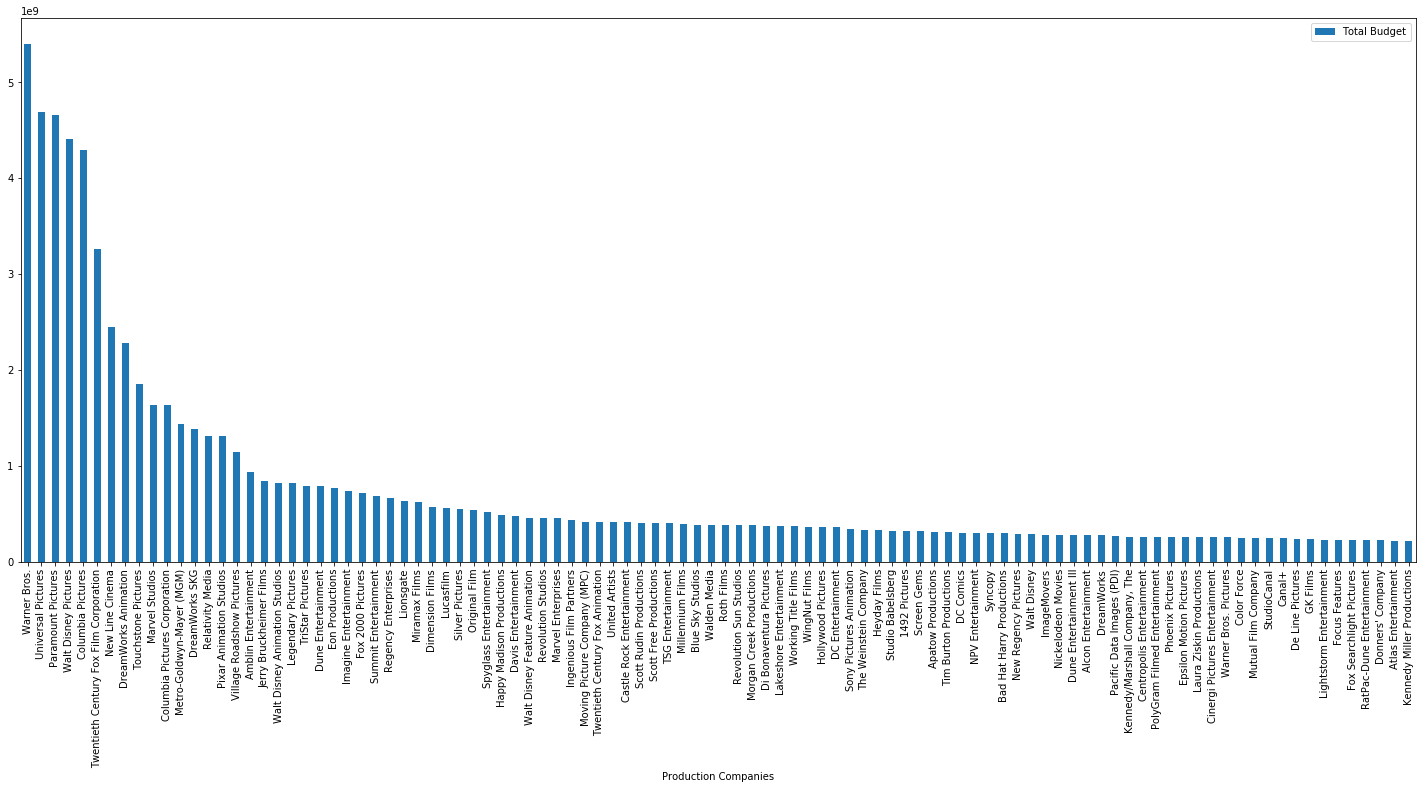

In [364]:
# visualize the top 100 production companies and their approximate budgets
pd.DataFrame(sorted(all_prod_companies.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:100], 
             columns=['Production Companies','Total Budget']).set_index('Production Companies').plot(kind='bar', figsize=(25,10))

In [365]:
# take the top 20 production companies
top_prod_companies = sorted(all_prod_companies.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:20]
print(top_prod_companies)

[('Warner Bros.', 5402510295.956349), ('Universal Pictures', 4696131190.183983), ('Paramount Pictures', 4661777112.341272), ('Walt Disney Pictures', 4407307777.777777), ('Columbia Pictures', 4292847549.852814), ('Twentieth Century Fox Film Corporation', 3257765503.3910527), ('New Line Cinema', 2450678214.2857146), ('DreamWorks Animation', 2277750000.0), ('Touchstone Pictures', 1854036210.1150794), ('Marvel Studios', 1633333333.3333333), ('Columbia Pictures Corporation', 1633230952.380952), ('Metro-Goldwyn-Mayer (MGM)', 1440338225.1428578), ('DreamWorks SKG', 1380953174.6031747), ('Relativity Media', 1315279808.743146), ('Pixar Animation Studios', 1315000000.0), ('Village Roadshow Pictures', 1143118254.718254), ('Amblin Entertainment', 935883333.3333336), ('Jerry Bruckheimer Films', 842499999.9999999), ('Walt Disney Animation Studios', 820000000.0), ('Legendary Pictures', 814646825.3968253)]


It appears that only the top couple dozen stand out from the rest.

In [366]:
# drop budget amounts
top_prod_companies = [i[0] for i in top_prod_companies]

# create dataframe with top production companies as individual columns for each movie
prod_companies_df = pd.concat([movies_credits_omdb_franch_cpi[['movie_id','title','production_companies_name']],
                               pd.DataFrame(columns=top_prod_companies)], sort=False)
print(movies_credits_omdb_franch_cpi.columns)

Index(['budget', 'original_language', 'overview', 'popularity', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count',
       'release_month', 'release_year', 'genres_name', 'keywords_name',
       'production_companies_name', 'production_countries_name',
       'spoken_languages_name', 'movie_id', 'cast_name', 'cast_gender',
       'crew_name', 'crew_job', 'director', 'Rated', 'Plot', 'Awards',
       'Metascore', 'imdbRating', 'Response', 'Rotten Tomatoes',
       'Oscar Awards', 'Oscar Nominations', 'BAFTA Film Awards',
       'BAFTA Film Nominations', 'Golden Globe Awards',
       'Golden Globe Nominations', 'Other Awards', 'Other Nominations',
       'Franchise', 'CPI', 'CPI Multiplier', 'adj_revenue', 'adj_budget'],
      dtype='object')


In [367]:
# apply binary conversion
for p_c in top_prod_companies:
    prod_companies_df[p_c] = movies_credits_omdb_franch_cpi['production_companies_name'].apply(lambda x: list_to_binary(p_c, x))
    
with pd.option_context('display.max_columns', None):
    display(prod_companies_df.head(3))

,movie_id,title,production_companies_name,Warner Bros.,Universal Pictures,Paramount Pictures,Walt Disney Pictures,Columbia Pictures,Twentieth Century Fox Film Corporation,New Line Cinema,DreamWorks Animation,Touchstone Pictures,Marvel Studios,Columbia Pictures Corporation,Metro-Goldwyn-Mayer (MGM),DreamWorks SKG,Relativity Media,Pixar Animation Studios,Village Roadshow Pictures,Amblin Entertainment,Jerry Bruckheimer Films,Walt Disney Animation Studios,Legendary Pictures
0,19995.0,Avatar,"[Ingenious Film Partners, Twentieth Century Fo...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,285.0,Pirates of the Caribbean: At World's End,"[Walt Disney Pictures, Jerry Bruckheimer Films...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,206647.0,Spectre,"[Columbia Pictures, Danjaq, B24]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [368]:
'''
Breakout all production companies lists into rows for tableau
'''
prod_companies_df_tableau = movies_credits_omdb_franch_cpi['production_companies_name'].apply(pd.Series) \
                                        .merge(movies_credits_omdb_franch_cpi[['movie_id','title','production_companies_name']], 
                                               left_index = True, right_index = True) \
                                        .melt(id_vars = ['title', 'movie_id', 'production_companies_name'], value_name = "production company") \
                                        .drop("variable", axis = 1) \
                                        .dropna()

#### Production Countries

In [369]:
'''
Convert production_countries_name to binary columns
'''
# create unique list of possible production countries (countries the films were produced in)
all_prod_countries = []
for i,r in movies_credits_omdb_franch_cpi.iterrows():
    prod_countries = r['production_countries_name']
    
    for p_c in prod_countries:
        if p_c not in all_prod_countries:
            all_prod_countries.append(p_c)
            
print(all_prod_countries)

['United States of America', 'United Kingdom', 'Jamaica', 'Bahamas', 'Dominica', 'Czech Republic', 'Poland', 'Slovenia', 'New Zealand', 'Germany', 'China', 'Canada', 'Italy', 'Japan', 'Malta', 'Australia', 'France', 'Belgium', 'India', 'Netherlands', 'Spain', 'United Arab Emirates', 'Hong Kong', 'Taiwan', 'Ireland', 'Morocco', 'Hungary', 'Singapore', 'Norway', 'Sweden', 'South Africa', 'Russia', 'Romania', 'Mexico', 'Monaco', 'Switzerland', 'Pakistan', 'Malaysia', 'Finland', 'Iceland', 'Denmark', 'Tunisia', 'Philippines', 'Bulgaria', 'South Korea', 'Brazil', 'Peru', 'Luxembourg', 'Bosnia and Herzegovina', 'Kazakhstan', 'Portugal', 'Aruba', 'Libyan Arab Jamahiriya', 'Serbia', 'Ukraine', 'Chile', 'Argentina', 'Panama', 'Austria', 'Greece', 'Lithuania', 'Cambodia', 'Thailand', 'Slovakia', 'Israel', 'Fiji', 'Serbia and Montenegro', 'Turkey', 'Nigeria', 'Cyprus', 'Jordan', 'Bolivia', 'Ecuador', 'Colombia', 'Egypt', 'Lebanon', 'Kyrgyz Republic', 'Algeria', 'Indonesia', 'Guyana', 'Iran', 'Gua

In [370]:
# create dataframe with top production companies as individual columns for each movie
prod_countries_df = pd.concat([movies_credits_omdb_franch_cpi[['movie_id','title','production_countries_name']],
                               pd.DataFrame(columns=all_prod_countries)], sort=False)
print(prod_countries_df.columns)

Index(['movie_id', 'title', 'production_countries_name',
       'United States of America', 'United Kingdom', 'Jamaica', 'Bahamas',
       'Dominica', 'Czech Republic', 'Poland', 'Slovenia', 'New Zealand',
       'Germany', 'China', 'Canada', 'Italy', 'Japan', 'Malta', 'Australia',
       'France', 'Belgium', 'India', 'Netherlands', 'Spain',
       'United Arab Emirates', 'Hong Kong', 'Taiwan', 'Ireland', 'Morocco',
       'Hungary', 'Singapore', 'Norway', 'Sweden', 'South Africa', 'Russia',
       'Romania', 'Mexico', 'Monaco', 'Switzerland', 'Pakistan', 'Malaysia',
       'Finland', 'Iceland', 'Denmark', 'Tunisia', 'Philippines', 'Bulgaria',
       'South Korea', 'Brazil', 'Peru', 'Luxembourg', 'Bosnia and Herzegovina',
       'Kazakhstan', 'Portugal', 'Aruba', 'Libyan Arab Jamahiriya', 'Serbia',
       'Ukraine', 'Chile', 'Argentina', 'Panama', 'Austria', 'Greece',
       'Lithuania', 'Cambodia', 'Thailand', 'Slovakia', 'Israel', 'Fiji',
       'Serbia and Montenegro', 'Turkey', 'Ni

In [371]:
# apply binary conversion
for p_c in all_prod_countries:
    prod_countries_df[p_c] = movies_credits_omdb_franch_cpi['production_countries_name'].apply(lambda x: list_to_binary(p_c, x))
    
with pd.option_context('display.max_columns', None):
    display(prod_countries_df.head(3))

,movie_id,title,production_countries_name,United States of America,United Kingdom,Jamaica,Bahamas,Dominica,Czech Republic,Poland,Slovenia,New Zealand,Germany,China,Canada,Italy,Japan,Malta,Australia,France,Belgium,India,Netherlands,Spain,United Arab Emirates,Hong Kong,Taiwan,Ireland,Morocco,Hungary,Singapore,Norway,Sweden,South Africa,Russia,Romania,Mexico,Monaco,Switzerland,Pakistan,Malaysia,Finland,Iceland,Denmark,Tunisia,Philippines,Bulgaria,South Korea,Brazil,Peru,Luxembourg,Bosnia and Herzegovina,Kazakhstan,Portugal,Aruba,Libyan Arab Jamahiriya,Serbia,Ukraine,Chile,Argentina,Panama,Austria,Greece,Lithuania,Cambodia,Thailand,Slovakia,Israel,Fiji,Serbia and Montenegro,Turkey,Nigeria,Cyprus,Jordan,Bolivia,Ecuador,Colombia,Egypt,Lebanon,Kyrgyz Republic,Algeria,Indonesia,Guyana,Iran,Guadaloupe,Afghanistan,Angola,Cameroon,Kenya
0,19995.0,Avatar,"[United States of America, United Kingdom]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,285.0,Pirates of the Caribbean: At World's End,[United States of America],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,206647.0,Spectre,"[United Kingdom, United States of America]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [372]:
'''
Breakout all production countries lists into rows for tableau
'''
prod_countries_df_tableau = movies_credits_omdb_franch_cpi['production_countries_name'].apply(pd.Series) \
                                        .merge(movies_credits_omdb_franch_cpi[['movie_id','title','production_countries_name']], 
                                               left_index = True, right_index = True) \
                                        .melt(id_vars = ['title', 'movie_id', 'production_countries_name'], value_name = "production country") \
                                        .drop("variable", axis = 1) \
                                        .dropna()

#### Spoken Languages

In [373]:
'''
Convert spoken_languages_name to binary columns
'''
# create unique list of possible spoken languages
all_spoken_languages = []
for i,r in movies_credits_omdb_franch_cpi.iterrows():
    langs = r['spoken_languages_name']
    
    for l in langs:
        if l not in all_spoken_languages:
            all_spoken_languages.append(l)
            
print(all_spoken_languages)

['English', 'Español', 'Français', 'Italiano', 'Deutsch', 'Türkçe', 'ελληνικά', '普通话', 'ภาษาไทย', 'Íslenska', 'Pусский', 'svenska', 'Română', '日本語', 'Latin', 'हिन्दी', 'Português', '', 'فارسی', 'اردو', 'العربية', 'Český', '广州话 / 廣州話', '한국어/조선말', 'Norsk', 'தமிழ்', 'עִבְרִית', 'Dansk', 'Nederlands', 'Afrikaans', 'Gaeilge', 'Somali', 'suomi', 'Kiswahili', 'български език', 'Tiếng Việt', 'Magyar', 'Український', 'Esperanto', 'Polski', 'ਪੰਜਾਬੀ', 'Eesti', 'shqip', 'Srpski', 'Bosanski', 'Hrvatski', 'Slovenčina', 'қазақ', 'తెలుగు', 'Cymraeg', 'Wolof', 'isiZulu', 'پښتو', 'No Language', 'Galego', 'ქართული', 'বাংলা', '??????', 'Bahasa indonesia', 'Bamanankan']


In [374]:
# create dataframe with spoken languages as individual columns for each movie
spoken_languages_df = pd.concat([movies_credits_omdb_franch_cpi[['movie_id','title','spoken_languages_name']],
                               pd.DataFrame(columns=all_spoken_languages)], sort=False)
print(spoken_languages_df.columns)

Index(['movie_id', 'title', 'spoken_languages_name', 'English', 'Español',
       'Français', 'Italiano', 'Deutsch', 'Türkçe', 'ελληνικά', '普通话',
       'ภาษาไทย', 'Íslenska', 'Pусский', 'svenska', 'Română', '日本語', 'Latin',
       'हिन्दी', 'Português', '', 'فارسی', 'اردو', 'العربية', 'Český',
       '广州话 / 廣州話', '한국어/조선말', 'Norsk', 'தமிழ்', 'עִבְרִית', 'Dansk',
       'Nederlands', 'Afrikaans', 'Gaeilge', 'Somali', 'suomi', 'Kiswahili',
       'български език', 'Tiếng Việt', 'Magyar', 'Український', 'Esperanto',
       'Polski', 'ਪੰਜਾਬੀ', 'Eesti', 'shqip', 'Srpski', 'Bosanski', 'Hrvatski',
       'Slovenčina', 'қазақ', 'తెలుగు', 'Cymraeg', 'Wolof', 'isiZulu', 'پښتو',
       'No Language', 'Galego', 'ქართული', 'বাংলা', '??????',
       'Bahasa indonesia', 'Bamanankan'],
      dtype='object')


In [375]:
# apply binary conversion
for langs in all_spoken_languages:
    spoken_languages_df[langs] = movies_credits_omdb_franch_cpi['spoken_languages_name'].apply(lambda x: list_to_binary(langs, x))
    
with pd.option_context('display.max_columns', None):
    display(spoken_languages_df.head(3))

,movie_id,title,spoken_languages_name,English,Español,Français,Italiano,Deutsch,Türkçe,ελληνικά,普通话,ภาษาไทย,Íslenska,Pусский,svenska,Română,日本語,Latin,हिन्दी,Português,,فارسی,اردو,العربية,Český,广州话 / 廣州話,한국어/조선말,Norsk,தமிழ்,עִבְרִית,Dansk,Nederlands,Afrikaans,Gaeilge,Somali,suomi,Kiswahili,български език,Tiếng Việt,Magyar,Український,Esperanto,Polski,ਪੰਜਾਬੀ,Eesti,shqip,Srpski,Bosanski,Hrvatski,Slovenčina,қазақ,తెలుగు,Cymraeg,Wolof,isiZulu,پښتو,No Language,Galego,ქართული,বাংলা,??????,Bahasa indonesia,Bamanankan
0,19995.0,Avatar,"[English, Español]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,285.0,Pirates of the Caribbean: At World's End,[English],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,206647.0,Spectre,"[Français, English, Español, Italiano, Deutsch]",1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [376]:
'''
Breakout all spoken language lists into rows for tableau
'''
spoken_languages_df_tableau = movies_credits_omdb_franch_cpi['spoken_languages_name'].apply(pd.Series) \
                                        .merge(movies_credits_omdb_franch_cpi[['movie_id','title','spoken_languages_name']], 
                                               left_index = True, right_index = True) \
                                        .melt(id_vars = ['title', 'movie_id', 'spoken_languages_name'], value_name = "spoken languages") \
                                        .drop("variable", axis = 1) \
                                        .dropna()

#### Cast

In [377]:
'''
Convert cast to binary columns
Since there are so many actors, limiting to the two lead actors
'''
# create unique list of possible lead actors
all_actors = []
for i,r in movies_credits_omdb_franch_cpi.iterrows():
    actors = r["cast_name"][:2]
    
    for a in actors:
        if a not in all_actors:
            all_actors.append(a)

print(len(all_actors)) # still far too many actors

3818


---
Determining which actors to retain in the dataframe (and, ultimately, to include as features for a machine learning model) is complicated by the fact that the available metrics do not necessarily indicate which actors performed the best.

Awards/high ratings may have been given for the directing or screenplay, budgets were likely spent more on special effects costs than actor salaries, and high revenues may also be due to a compilation of these factors, further exacerbated by the fact that certain genres appeal to larger audiences and typically earn more irregardless of director, actors, etc.

The following is an exploration of actors in regards to some of these metrics in an attempt to see if any actors stand out. (Limiting to the two lead actors to filter out actors in minor roles that probably didn't have as strong an influence on the movie's performance)

---

In [378]:
'''
Lead Actors by Total Revenues
'''
all_actors_revenues = {}
for i,r in movies_credits_omdb_franch_cpi.iterrows():
    actors = r['cast_name'][:2]
    
    for a in actors:
        if a not in all_actors_revenues:
            all_actors_revenues[a] = r['revenue']
        else:
            all_actors_revenues[a] += r['revenue']

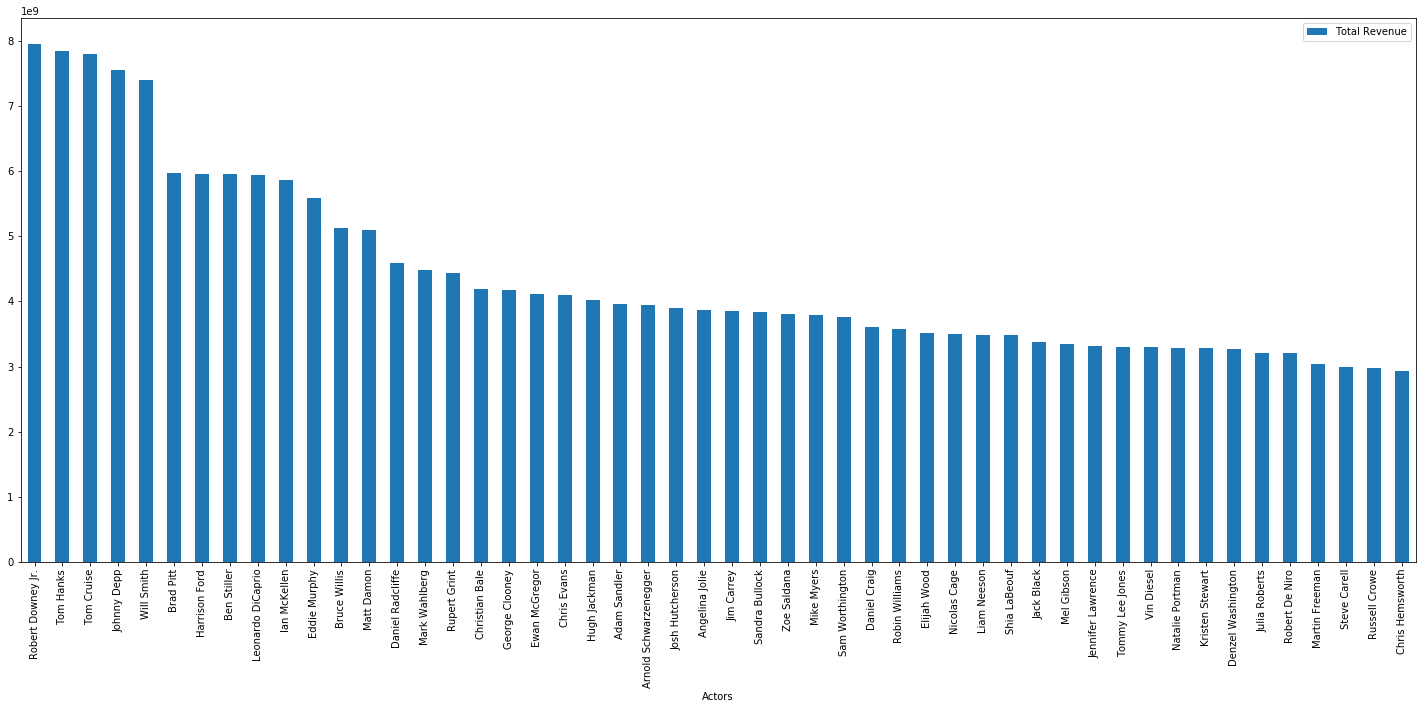

In [379]:
# Visualize actors by total revenue
pd.DataFrame(sorted(all_actors_revenues.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:50], 
             columns=['Actors','Total Revenue']).set_index('Actors').plot(kind='bar', figsize=(25,10))

In [380]:
'''
Lead Actors by Number of Movies
'''
all_actors_numMovies = {}
for i,r in movies_credits_omdb_franch_cpi.iterrows():
    actors = r['cast_name'][:2]
    
    for a in actors:
        if a not in all_actors_numMovies:
            all_actors_numMovies[a] = 0
        else:
            all_actors_numMovies[a] += 1

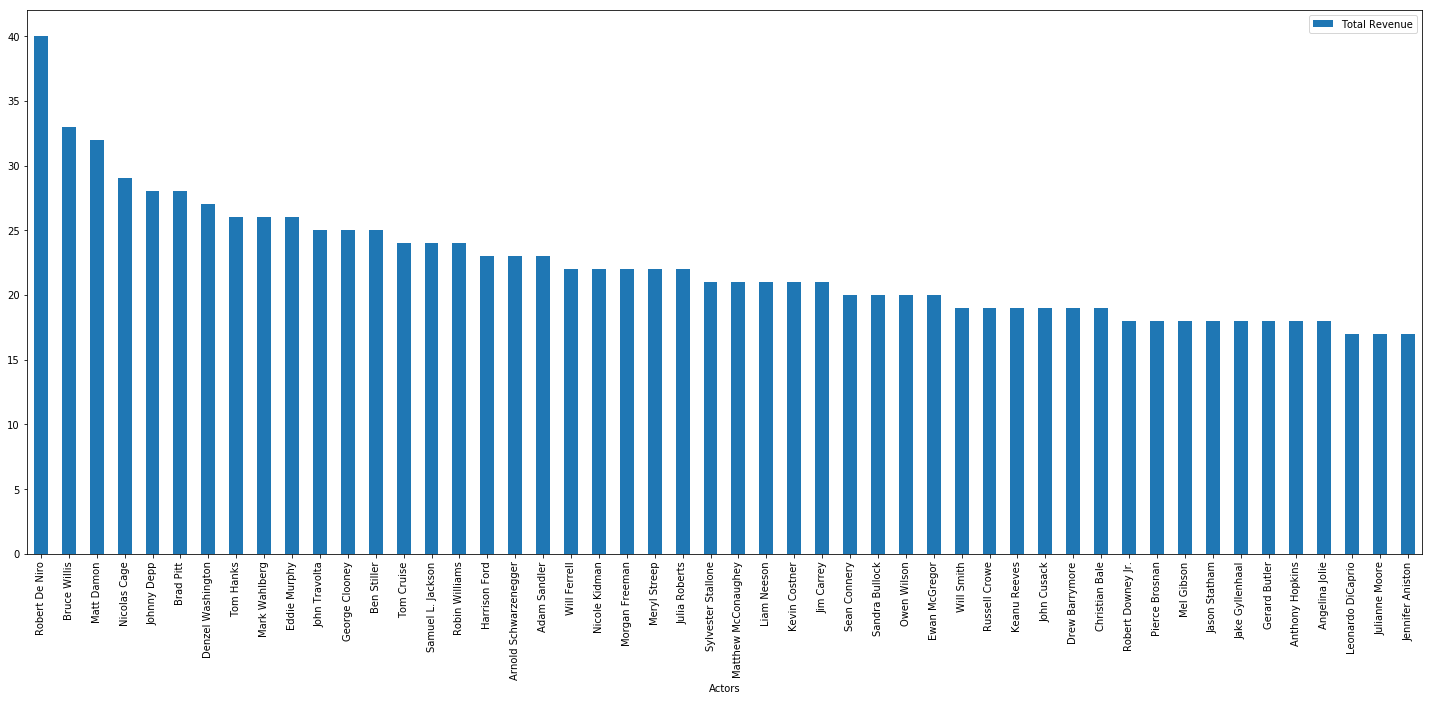

In [381]:
# Visualize actors by number of movies
pd.DataFrame(sorted(all_actors_numMovies.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:50], 
             columns=['Actors','Total Revenue']).set_index('Actors').plot(kind='bar', figsize=(25,10))

In [382]:
'''
Lead Actors by Average Revenues
'''
all_actors_avgRevenues = {}

for actor in all_actors_revenues:
    if all_actors_numMovies[actor] == 0:
        all_actors_avgRevenues[actor] = 0
    else: all_actors_avgRevenues[actor] = all_actors_revenues[actor] / all_actors_numMovies[actor]

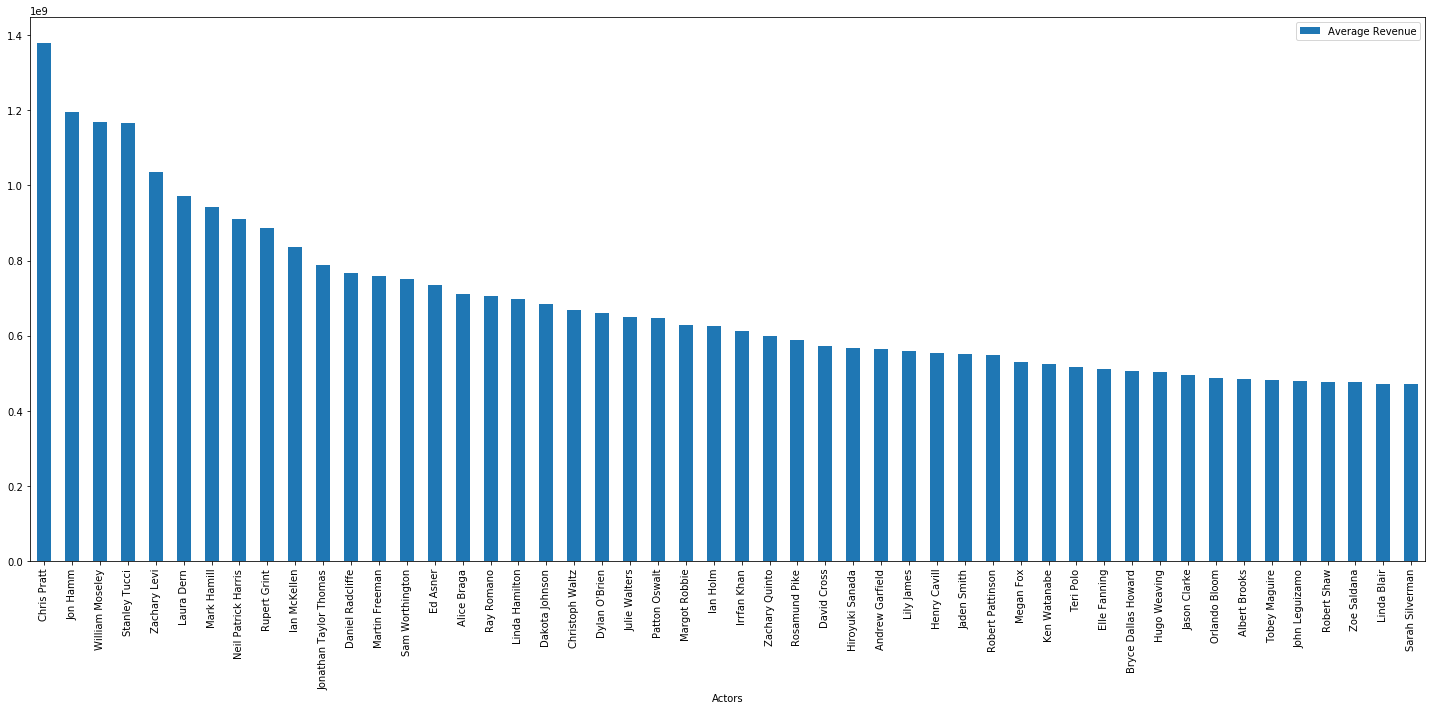

In [383]:
# Visualize actors by average revenues
pd.DataFrame(sorted(all_actors_avgRevenues.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:50], 
             columns=['Actors','Average Revenue']).set_index('Actors').plot(kind='bar', figsize=(25,10))

---
As a result of these quick, preliminary visuals, I am realizing that the popularity of actors is incredibly volatile. Furthermore, it is especially difficult to identify which actors/actresses are "better" than others with the metrics at hand.

For actors to be used reliably as features of a model, some metric that more directly pertains to each actor's performance is needed.

As such, I will create a dataframe for exploratory analysis of actors in Tableau, but will not be considering them for modeling purposes.

---

In [384]:
'''
Breakout all cast lists into rows
'''
actors_df_tableau = movies_credits_omdb_franch_cpi['cast_name'].apply(pd.Series) \
                                        .merge(movies_credits_omdb_franch_cpi[['movie_id','title','cast_name']], 
                                               left_index = True, right_index = True) \
                                        .melt(id_vars = ['title', 'movie_id', 'cast_name'], value_name = "actors") \
                                        .drop("variable", axis = 1) \
                                        .dropna()

---
Below are additional metrics I thought might be useful

---

In [385]:
def get_gender(genders_list, idx):
    if len(genders_list) < idx+1: return 0
    
    return genders_list[idx]

In [386]:
def get_two_genders(genders_list):
    if len(genders_list) == 0:
        return "Unavailable"
    if len(genders_list) == 1:
        if genders_list[0] == 0: return "Unknown"
        elif genders_list[0] == 1: return "Female"
        else: return "Male"
    if len(genders_list) >= 2:
        if genders_list[0] == 0:
            if genders_list[1] == 0: return "Both Unknown"
            elif genders_list[1] == 1: return "Unknown, Female"
            else: return "Unkown, Male"
        elif genders_list[0] == 1:
            if genders_list[1] == 0: return "Female, Unknown"
            elif genders_list[1] == 1: return "Female, Female"
            else: return "Female, Male"

        else:
            if genders_list[1] == 0: return "Male, Unknown"
            elif genders_list[1] == 1: return "Male, Female"
            else: return "Male, Male"

In [387]:
'''
Genders of the two lead actors might offer some interesting insights
'''
movies_credits_omdb_franch_cpi['lead_genders'] = movies_credits_omdb_franch_cpi['cast_gender'].apply(lambda x: get_two_genders(x))
movies_credits_omdb_franch_cpi['gender_1'] = movies_credits_omdb_franch_cpi['cast_gender'].apply(lambda x: get_gender(x,0))
movies_credits_omdb_franch_cpi['gender_2'] = movies_credits_omdb_franch_cpi['cast_gender'].apply(lambda x: get_gender(x,1))

with pd.option_context('display.max_columns', None):
    display(movies_credits_omdb_franch_cpi.head(3))

,budget,original_language,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,release_month,release_year,genres_name,keywords_name,production_companies_name,production_countries_name,spoken_languages_name,movie_id,cast_name,cast_gender,crew_name,crew_job,director,Rated,Plot,Awards,Metascore,imdbRating,Response,Rotten Tomatoes,Oscar Awards,Oscar Nominations,BAFTA Film Awards,BAFTA Film Nominations,Golden Globe Awards,Golden Globe Nominations,Other Awards,Other Nominations,Franchise,CPI,CPI Multiplier,adj_revenue,adj_budget,lead_genders,gender_1,gender_2
0,237000000,en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Avatar,7.2,11800,12,2009.0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]",19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Editor, Production Design, Sound Designer, Su...",James Cameron,PG-13,A paraplegic marine dispatched to the moon Pan...,Won 3 Oscars. Another 85 wins & 128 nominations.,83,7.8,1.0,82,3,0,0,0,0,0,85,128,Avatar Collection,215.949,0.859557,2.396414e+09,2.037149e+08,"Male, Female",2,1
1,300000000,en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,5,2007.0,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English],285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Director of Photography, Director, Producer, ...",Gore Verbinski,PG-13,"Captain Barbossa, Will Turner and Elizabeth Sw...",Nominated for 2 Oscars. Another 20 wins & 44 n...,50,7.1,1.0,44,0,2,0,0,0,0,20,44,Pirates of the Caribbean Collection,207.9,0.827519,7.952454e+08,2.482556e+08,"Male, Male",2,2
2,245000000,en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,Spectre,6.3,4466,10,2015.0,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]",206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, ...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Original Music Composer, Director, Set Decora...",Sam Mendes,PG-13,A cryptic message from 007's past sends him pi...,Won 1 Oscar. Another 7 wins & 32 nominations.,60,6.8,1.0,64,1,0,0,0,0,0,7,32,James Bond Collection,237.838,0.946683,8.337196e+08,2.319373e+08,"Male, Male",2,2


In [388]:
'''
Calculate profit = (revenue - budget)
'''
movies_credits_omdb_franch_cpi['Profit'] = movies_credits_omdb_franch_cpi['revenue'] - movies_credits_omdb_franch_cpi['budget']

In [389]:
'''
Create binary column for Franchise
'''
movies_credits_omdb_franch_cpi['is_Franchise'] = np.where(movies_credits_omdb_franch_cpi['Franchise']=='', 0, 1)

### Write to Excel for Visualization in Tableau

In [390]:
'''
Write to excel for Tableau analysis
'''    
# create a Pandas Excel writer using XlsxWriter as the engine (source: John McNamara)
writer = pd.ExcelWriter('Full Output.xlsx', engine='xlsxwriter')

movies_credits_omdb_franch_cpi.to_excel(writer, sheet_name='movies_credits_omdb_franch_cpi')
genres_df_tableau.to_excel(writer, sheet_name='genres_df')
prod_companies_df_tableau.to_excel(writer, sheet_name='prod_companies_df')
prod_countries_df_tableau.to_excel(writer, sheet_name='prod_countries_df')
spoken_languages_df_tableau.to_excel(writer, sheet_name='spoken_languages_df')
actors_df_tableau.to_excel(writer, sheet_name='actors_df')

writer.save()

## Revenue Forecasting
The following section sets out to utilize Machine Learning to project revenues based on the features available

In [391]:
# drop CPI adjusted revenue and Profit as they are directly related to revenue
# drop adj_budget as it is likely to have high colinearity with unadjusted budget
movies_credits_omdb_franch_cpi.drop(['Profit','adj_revenue','adj_budget'], axis=1, inplace=True)

# set indexes for join
movies_credits_omdb_franch_cpi.set_index('movie_id', inplace=True)
genres_df.set_index('movie_id', inplace=True)
prod_companies_df.set_index('movie_id', inplace=True)
prod_countries_df.set_index('movie_id', inplace=True)
spoken_languages_df.set_index('movie_id', inplace=True)

In [392]:
# join all dataframes
full_df = pd.concat([movies_credits_omdb_franch_cpi, genres_df, prod_companies_df, prod_countries_df, spoken_languages_df], axis=1, join='inner')
with pd.option_context('display.max_columns', None):
    display(full_df.head(0))

,budget,original_language,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,release_month,release_year,genres_name,keywords_name,production_companies_name,production_countries_name,spoken_languages_name,cast_name,cast_gender,crew_name,crew_job,director,Rated,Plot,Awards,Metascore,imdbRating,Response,Rotten Tomatoes,Oscar Awards,Oscar Nominations,BAFTA Film Awards,BAFTA Film Nominations,Golden Globe Awards,Golden Globe Nominations,Other Awards,Other Nominations,Franchise,CPI,CPI Multiplier,lead_genders,gender_1,gender_2,is_Franchise,title,genres_name,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie,title,production_companies_name,Warner Bros.,Universal Pictures,Paramount Pictures,Walt Disney Pictures,Columbia Pictures,Twentieth Century Fox Film Corporation,New Line Cinema,DreamWorks Animation,Touchstone Pictures,Marvel Studios,Columbia Pictures Corporation,Metro-Goldwyn-Mayer (MGM),DreamWorks SKG,Relativity Media,Pixar Animation Studios,Village Roadshow Pictures,Amblin Entertainment,Jerry Bruckheimer Films,Walt Disney Animation Studios,Legendary Pictures,title,production_countries_name,United States of America,United Kingdom,Jamaica,Bahamas,Dominica,Czech Republic,Poland,Slovenia,New Zealand,Germany,China,Canada,Italy,Japan,Malta,Australia,France,Belgium,India,Netherlands,Spain,United Arab Emirates,Hong Kong,Taiwan,Ireland,Morocco,Hungary,Singapore,Norway,Sweden,South Africa,Russia,Romania,Mexico,Monaco,Switzerland,Pakistan,Malaysia,Finland,Iceland,Denmark,Tunisia,Philippines,Bulgaria,South Korea,Brazil,Peru,Luxembourg,Bosnia and Herzegovina,Kazakhstan,Portugal,Aruba,Libyan Arab Jamahiriya,Serbia,Ukraine,Chile,Argentina,Panama,Austria,Greece,Lithuania,Cambodia,Thailand,Slovakia,Israel,Fiji,Serbia and Montenegro,Turkey,Nigeria,Cyprus,Jordan,Bolivia,Ecuador,Colombia,Egypt,Lebanon,Kyrgyz Republic,Algeria,Indonesia,Guyana,Iran,Guadaloupe,Afghanistan,Angola,Cameroon,Kenya,title,spoken_languages_name,English,Español,Français,Italiano,Deutsch,Türkçe,ελληνικά,普通话,ภาษาไทย,Íslenska,Pусский,svenska,Română,日本語,Latin,हिन्दी,Português,,فارسی,اردو,العربية,Český,广州话 / 廣州話,한국어/조선말,Norsk,தமிழ்,עִבְרִית,Dansk,Nederlands,Afrikaans,Gaeilge,Somali,suomi,Kiswahili,български език,Tiếng Việt,Magyar,Український,Esperanto,Polski,ਪੰਜਾਬੀ,Eesti,shqip,Srpski,Bosanski,Hrvatski,Slovenčina,қазақ,తెలుగు,Cymraeg,Wolof,isiZulu,پښتو,No Language,Galego,ქართული,বাংলা,??????,Bahasa indonesia,Bamanankan
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [393]:
# drop unneeded columns
full_df.drop(['original_language','overview','release_date','title','genres_name','keywords_name','production_companies_name',
             'production_countries_name','spoken_languages_name','cast_name','cast_gender','crew_name','crew_job','director','Rated',
             'Plot','Awards','Response','Franchise','CPI','CPI Multiplier','lead_genders'], axis=1, inplace=True)

In [394]:
with pd.option_context('display.max_columns', None):
    display(full_df.head(0))

,budget,popularity,revenue,runtime,vote_average,vote_count,release_month,release_year,Metascore,imdbRating,Rotten Tomatoes,Oscar Awards,Oscar Nominations,BAFTA Film Awards,BAFTA Film Nominations,Golden Globe Awards,Golden Globe Nominations,Other Awards,Other Nominations,gender_1,gender_2,is_Franchise,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie,Warner Bros.,Universal Pictures,Paramount Pictures,Walt Disney Pictures,Columbia Pictures,Twentieth Century Fox Film Corporation,New Line Cinema,DreamWorks Animation,Touchstone Pictures,Marvel Studios,Columbia Pictures Corporation,Metro-Goldwyn-Mayer (MGM),DreamWorks SKG,Relativity Media,Pixar Animation Studios,Village Roadshow Pictures,Amblin Entertainment,Jerry Bruckheimer Films,Walt Disney Animation Studios,Legendary Pictures,United States of America,United Kingdom,Jamaica,Bahamas,Dominica,Czech Republic,Poland,Slovenia,New Zealand,Germany,China,Canada,Italy,Japan,Malta,Australia,France,Belgium,India,Netherlands,Spain,United Arab Emirates,Hong Kong,Taiwan,Ireland,Morocco,Hungary,Singapore,Norway,Sweden,South Africa,Russia,Romania,Mexico,Monaco,Switzerland,Pakistan,Malaysia,Finland,Iceland,Denmark,Tunisia,Philippines,Bulgaria,South Korea,Brazil,Peru,Luxembourg,Bosnia and Herzegovina,Kazakhstan,Portugal,Aruba,Libyan Arab Jamahiriya,Serbia,Ukraine,Chile,Argentina,Panama,Austria,Greece,Lithuania,Cambodia,Thailand,Slovakia,Israel,Fiji,Serbia and Montenegro,Turkey,Nigeria,Cyprus,Jordan,Bolivia,Ecuador,Colombia,Egypt,Lebanon,Kyrgyz Republic,Algeria,Indonesia,Guyana,Iran,Guadaloupe,Afghanistan,Angola,Cameroon,Kenya,English,Español,Français,Italiano,Deutsch,Türkçe,ελληνικά,普通话,ภาษาไทย,Íslenska,Pусский,svenska,Română,日本語,Latin,हिन्दी,Português,,فارسی,اردو,العربية,Český,广州话 / 廣州話,한국어/조선말,Norsk,தமிழ்,עִבְרִית,Dansk,Nederlands,Afrikaans,Gaeilge,Somali,suomi,Kiswahili,български език,Tiếng Việt,Magyar,Український,Esperanto,Polski,ਪੰਜਾਬੀ,Eesti,shqip,Srpski,Bosanski,Hrvatski,Slovenčina,қазақ,తెలుగు,Cymraeg,Wolof,isiZulu,پښتو,No Language,Galego,ქართული,বাংলা,??????,Bahasa indonesia,Bamanankan
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Random Forest

In [395]:
# split training data (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(full_df.drop('revenue', axis=1), np.log1p(full_df['revenue']), test_size=0.2)

In [400]:
from sklearn.model_selection import GridSearchCV

# Find the best parameters
RF_tester = RandomForestRegressor()
param_grid = {
                'bootstrap': [True, False],
                'max_depth': [15, 30, 50],
                'max_features': [20, 30, 50],
                'min_samples_leaf': [2, 3, 5],
                'min_samples_split': [2, 3, 5],
                'n_estimators': [40, 60, 100]
             }

gs = GridSearchCV(estimator=RF_tester, param_grid=param_grid, cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.6393841852805366
{'bootstrap': True, 'max_depth': 15, 'max_features': 50, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}


In [409]:
# Functions for scoring model
def rmse(x, y):
    return np.sqrt(mean_squared_error(x,y))
                   
def print_score(model):
    print('Train R2: {}'.format(model.score(X_train, y_train)))
    print('Test R2: {}'.format(model.score(X_test, y_test)))
    print('Train log(RMSE): {}'.format(rmse(model.predict(X_train), y_train)))
    print('Test log(RMSE): {}'.format(rmse(model.predict(X_test), y_test)))

In [410]:
# default Random Forest
RF = RandomForestRegressor(bootstrap=True, max_depth=15, max_features=50, n_estimators=100, n_jobs = -1)
RF.fit(X_train, y_train)

# evaluate
print_score(RF)

Train R2: 0.9218231143547198
Test R2: 0.6000246814330185
Train log(RMSE): 2.2649601923207046
Test log(RMSE): 5.175720708444529


The difference in R^2 between the train and test datasets indicate the model is still overfitting and requires additional tuning.

In [411]:
# Showcase Random Forest features, sorted by importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['Feature']), 
           pd.DataFrame(RF.feature_importances_, columns = ['Importance'])), 
          axis = 1).sort_values(by='Importance', ascending = False)

,Feature,Importance
0,budget,3.130516e-01
4,vote_count,2.158203e-01
1,popularity,1.200539e-01
17,Other Nominations,3.364253e-02
6,release_year,3.015222e-02
2,runtime,2.841579e-02
3,vote_average,2.626191e-02
9,Rotten Tomatoes,2.342900e-02
7,Metascore,2.135355e-02
8,imdbRating,1.884572e-02
